## About this notebook

+ This notebook is training NFNet-F3 that is part of the 2nd place solution.
+ Details of the solution are in the following link
  + [Discussion](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/300929)
+ CV : 17.59169
  + I don't do submissions on single models.
+ Training environment : RTX3090
  
### Reference

Some of the code is based on this [notebook](https://www.kaggle.com/phalanx/train-swin-t-pytorch-lightning). Thank you


### Training log

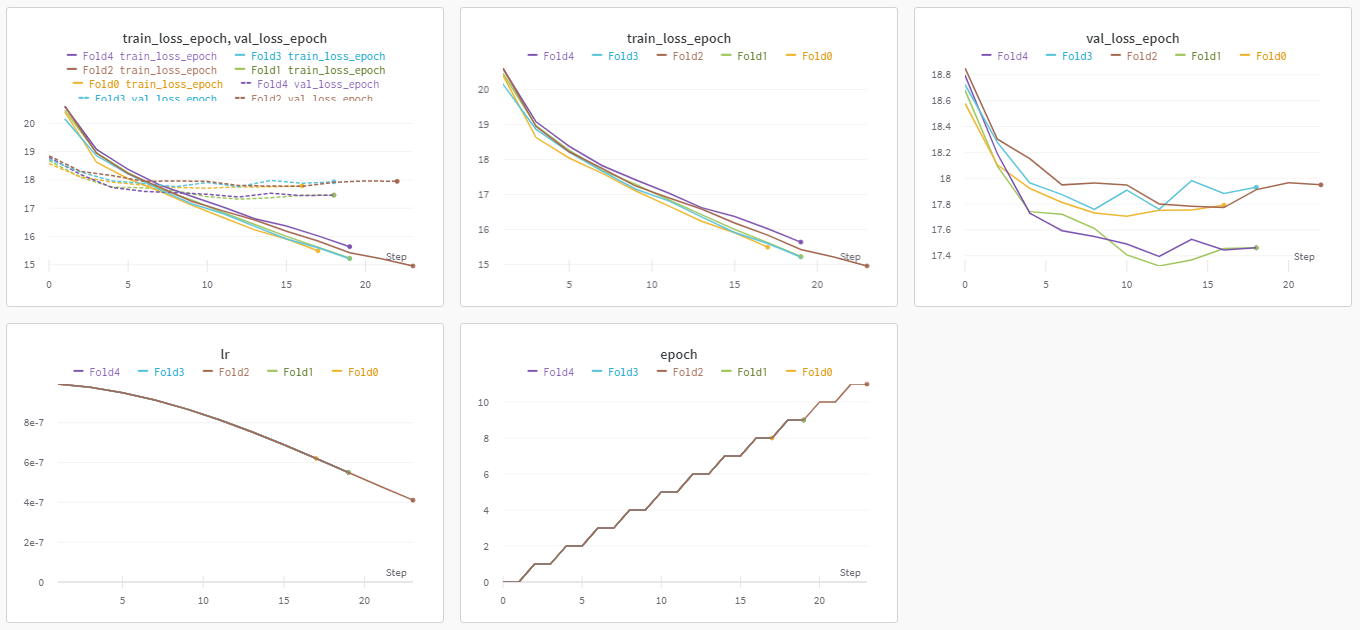

## Get env

In [ ]:
!nvidia-smi

In [ ]:
# 環境によって処理を変えるためのもの
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

In [ ]:
if IN_KAGGLE or IN_COLAB:
    !pip install --upgrade -q wandb
    !pip install -q pytorch-lightning
    !pip install torch_optimizer==0.1.0
    !pip install einops
    !pip install timm

## Import Libraries

In [ ]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
import pickle
import gc
from collections import defaultdict
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Visualizations
# from PIL import Image
# import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import RobustScaler, normalize, QuantileTransformer, StandardScaler
# from sklearn.metrics import mean_absolute_error #[roc_auc_score, accuracy_score]

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.optimizer import Optimizer, required
import torch_optimizer as optim
from einops.layers.torch import Rearrange

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, CSVLogger

# Pytorch Image Models
import timm
from torchvision.io import read_image
import torchvision.transforms as T

# Weights and Biases Tool
import wandb
#os.environ["WANDB_API_KEY"]='hoge'
wandb.login()

## Config

In [ ]:
class CFG:
    debug = True
    competition='PetFinder2'
    exp_name = "kaggle_test"
    seed = 29
    # model
    model_name = 'dm_nfnet_f3'
    pretrained = True
    img_size = 512
    in_chans = 3
    # data
    target_col = 'Pawpularity'
    target_size = 1
    # optimizer
    optimizer_name = 'AdamW'#['RAdam', 'sgd', 'AdamW']
    lr = 1e-6
    weight_decay = 1e-6
    amsgrad = False
    
    # scheduler
    epochs = 20
    scheduler = 'CosineAnnealingLR' #['CosineAnnealingLR', 'ReduceLROnPlateau']
    T_max = 300
    min_lr = 1e-7
    # scheduler = 'ReduceLROnPlateau' #['CosineAnnealingLR', 'ReduceLROnPlateau']
    # factor = 0.5
    # patience = 10
    # eps = 1e-6
    # min_lr = 1e-05

    # criterion
    criterion_name = 'BCEWithLogitsLoss'

    mixup = {'alpha':2}
    
    # training
    train = True
    inference = True
    n_fold = 5
    trn_fold = [0]
    precision = 16 #[16, 32, 64]
    grad_acc = 1
    # DataLoader
    loader = {
        "train": {
            "batch_size": 8,
            "num_workers": 0,
            "shuffle": True,
            "pin_memory": True,
            "drop_last": True
        },
        "valid": {
            "batch_size": 8,
            "num_workers": 0,
            "shuffle": False,
            "pin_memory": True,
            "drop_last": False
        }
    }
    # pl
    trainer = {
        'gpus': 1,
        'progress_bar_refresh_rate': 1,
        'benchmark': False,
        'deterministic': True,
        }

    feature_cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
        'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur',
        ]
    
seed_everything(CFG.seed)
if not LOCAL:
    CFG.loader["train"]["num_workers"] = 4
    CFG.loader["valid"]["num_workers"] = 4

## Directory & LoadData

In [ ]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/petfinder-pawpularity-score/')
    OUTPUT_DIR = './'
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/petfinder-pawpularity-score/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/petfinder-pawpularity-score/data/input/")
    OUTPUT_DIR = f'F:/Kaggle/petfinder-pawpularity-score/data/output/{CFG.exp_name}/'
    
df_train = pd.read_csv(INPUT_DIR / "train.csv")
df_oof = df_train[["Id","Pawpularity"]].copy()

df_train["Id"] = df_train["Id"].apply(lambda x: os.path.join(INPUT_DIR, "train", x + ".jpg"))

submission = pd.read_csv(INPUT_DIR / "sample_submission.csv")
display(df_train.head())

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if CFG.debug:
    CFG.epochs = 2
    CFG.loader["train"]["batch_size"] = 2
    CFG.trn_fold = [0]
    df_train  =df_train.head(500)
    

In [ ]:
df_train.isnull().sum()

## Utils

In [ ]:
# LINEに通知
import requests
def send_line_notification(message):
    env = ""
    if IN_COLAB: env = "colab"
    elif IN_KAGGLE: env = "kaggle"
    elif LOCAL: env = "local"
        
    line_token = 'hoge'
    endpoint = 'https://notify-api.line.me/api/notify'
    message = f"[{env}]{message}"
    payload = {'message': message}
    headers = {'Authorization': 'Bearer {}'.format(line_token)}
    requests.post(endpoint, data=payload, headers=headers)

## CV Split

In [ ]:
df_train["fold"] = -1
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col])):
    df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
df_oof['fold'] = df_train['fold']
print(df_train.groupby(['fold', CFG.target_col]).size())

## Transforms

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB
def get_default_transforms():
    transform = {
        "train": T.Compose(
            [
                T.RandomHorizontalFlip(),
#                 T.RandomVerticalFlip(),
                T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#                 T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
        "val": T.Compose(
            [
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
    }
    return transform

## Dataset

In [ ]:
class PetfinderDataset(Dataset):
    def __init__(self, df, feature_cols, image_size=224):
        self._X = df["Id"].values
        self.meta = df[feature_cols].values
        self._y = None
        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values
        self._transform = T.Compose([
                                        T.Resize(image_size),  # 1
                                        T.CenterCrop([image_size, image_size]),  # 2
                                    ]
                                    )

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        image = read_image(image_path)
        image = self._transform(image)
        features = torch.FloatTensor(self.meta[idx, :])
        
        if self._y is not None:
            label = self._y[idx]
            return image, features,  label
        return image, features 


In [ ]:
ds = PetfinderDataset(df_train, CFG.feature_cols, CFG.img_size)
for i in range(3):
    print("="*50)
    print(ds[0][i])
del ds

## DataModule

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                 df_train,
                 df_val,
                 df_test,
                 cfg):
        super().__init__()
        self._df_train = df_train
        self._df_val = df_val
        self._df_test = df_test
        self._cfg = cfg
        
    def setup(self, stage=None):
        self.train_dataset = PetfinderDataset(self._df_train, self._cfg.feature_cols, self._cfg.img_size)
        self.valid_dataset = PetfinderDataset(self._df_val, self._cfg.feature_cols, self._cfg.img_size)
        self.test_dataset = PetfinderDataset(self._df_test, self._cfg.feature_cols, self._cfg.img_size)
        
    # Trainer.fit() 時に呼び出される
    def train_dataloader(self):
        return DataLoader(self.train_dataset, **self._cfg.loader['train'])

    # Trainer.fit() 時に呼び出される
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, **self._cfg.loader['valid'])

    def test_dataloader(self):
        return DataLoader(self.test_dataset, **self._cfg.loader['valid'])

In [ ]:
Data = DataModule(df_train,df_train,df_train, CFG)
Data.setup()
sample_dataloader = Data.train_dataloader()
images, features, labels = iter(sample_dataloader).next()
plt.figure(figsize=(12, 12))
for it, (image, label) in enumerate(zip(images[:16], labels[:16])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Pawpularity: {int(label)}')

## Pytorch Lightning Module

In [ ]:
# ====================================================
# criterion
# ====================================================
def get_criterion(cfg):
    if cfg.criterion_name == 'BCEWithLogitsLoss':
        # plだとto(device)いらない
        criterion = nn.BCEWithLogitsLoss(reduction="mean")
    elif cfg.criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise NotImplementedError
    return criterion
# ====================================================
# optimizer
# ====================================================
def get_optimizer(model: nn.Module, config: dict):
    """
    input:
    model:model
    config:optimizer_nameやlrが入ったものを渡す
    
    output:optimizer
    """
    optimizer_name = config.optimizer_name
    if 'Adam' == optimizer_name:
        return Adam(model.parameters(),
                    lr=config.lr,
                    weight_decay=config.weight_decay,
                    amsgrad=config.amsgrad)
    elif 'RAdam' == optimizer_name:
        return optim.RAdam(model.parameters(),
                           lr=config.lr,
                           weight_decay=config.weight_decay)
    elif 'AdamW' == optimizer_name:
        return torch.optim.AdamW(model.parameters(),
                                 lr=config.lr,
                                 weight_decay=config.weight_decay)
    elif 'Ranger' == optimizer_name:
        return optim.Ranger(model.parameters(),
                            lr=config.lr)
    elif 'sgd' == optimizer_name:
        return SGD(model.parameters(),
                   lr=config.lr,
                   momentum=0.9,
                   nesterov=True,
                   weight_decay=config.weight_decay,)
    else:
        raise NotImplementedError

# ====================================================
# scheduler
# ====================================================
def get_scheduler(cfg, optimizer):
    if cfg.scheduler=='ReduceLROnPlateau':
        """
        factor : 学習率の減衰率
        patience : 何ステップ向上しなければ減衰するかの値
        eps : nanとかInf回避用の微小数
        """
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps, min_lr=cfg.min_lr)
    elif cfg.scheduler=='CosineAnnealingLR':
        """
        T_max : 1 半周期のステップサイズ
        eta_min : 最小学習率(極小値)
        """
        scheduler = CosineAnnealingLR(optimizer, T_max=cfg.T_max, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler=='CosineAnnealingWarmRestarts':
        """
        T_0 : 初期の繰りかえし回数
        T_mult : サイクルのスケール倍率
        """
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    else:
        raise NotImplementedError
    return scheduler

def get_lightning_scheduler(cfg, optimizer):
    scheduler = get_scheduler(cfg, optimizer)
    if cfg.scheduler=='ReduceLROnPlateau':
        return {'scheduler': scheduler,
                'monitor': 'val_loss_epoch',
                'interval': 'epoch',
                'frequency': 1}
    else:
        return {'scheduler': scheduler,
                'interval': 'step',
                'frequency': 1}


In [ ]:
# ====================================================
# model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.backbone = timm.create_model(model_name=self.cfg.model_name,
                                          pretrained=pretrained,
                                          in_chans=self.cfg.in_chans,
                                          num_classes=0)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc = nn.LazyLinear(self.cfg.target_size)
        
    def forward(self, x, features):
        f = self.backbone(x) # (bs, embedding_size)
        f = self.dropout1(f)
        if features.shape[1] != 0:
            f = torch.cat([f, features],dim=1)
            f =  self.dropout2(f)
        out = self.fc(f)
        return out
    
def get_model(cfg):
    model = CustomModel(cfg, pretrained=cfg.pretrained)
    return model


In [ ]:
# # modelの動作確認
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = get_model(CFG).to(device)
# Data = DataModule(df_train,df_train,df_train, CFG)
# Data.setup()
# sample_dataloader = Data.train_dataloader()
# images, features, labels = iter(sample_dataloader).next()
# images = images.to(device)
# features = features.to(device)
# labels = labels.to(device)
# labels = labels.float() / 100.0
# transform = get_default_transforms()
# images = transform["train"](images)
# output = model(images,features).squeeze(1)
# print(output)
# del Data, model, images, features, labels, output
# gc.collect()

In [ ]:
# criterion = get_criterion()
# criterion(output, labels)

In [ ]:
#schedulerの確認
model = get_model(CFG)
optimizer = get_optimizer(model, CFG)
scheduler = get_scheduler(CFG,optimizer)
from pylab import rcParams
lrs = []
for epoch in range(1, CFG.epochs+1):
    scheduler.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
print(lrs)
plt.plot(lrs)

In [ ]:
class Trainer(pl.LightningModule):
    """
    labelを[0,100]から[0,1]に変えて2クラス分類タスクにする
    """
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.model = get_model(cfg)
        self.criterion = get_criterion(cfg)
        self.transform = get_default_transforms()
    
    def forward(self, x, features):
        output = self.model(x, features)
        return output
    
    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        return {'loss': loss, 'pred': pred, 'labels': labels}
    
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        return {'pred': pred, 'labels': labels}

    def __share_step(self, batch, mode):
        images, features, labels = batch
        labels = labels.float() / 100.0
        images = self.transform[mode](images)

        logits = self.forward(images, features).squeeze(1)
        loss = self.criterion(logits, labels)

        pred = logits.sigmoid().detach().cpu() * 100.
        labels = labels.detach().cpu() * 100.
        
        return loss, pred, labels

    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train') 
        self.log("lr", self.optimizer.param_groups[0]['lr'], prog_bar=True, logger=True)
    
    
    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val') 

    def __share_epoch_end(self, outputs, mode):
        preds, labels = [], []
        for output in outputs:
            pred, label = output['pred'], output['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = torch.sqrt(((labels - preds) ** 2).mean())
        
        self.log(f"{mode}_loss_epoch", metrics)
        
    def predict_step(self, batch, batch_idx):
        _, pred, labels = self.__share_step(batch, 'val')
        return pred
    
    def configure_optimizers(self):
        self.optimizer = get_optimizer(self, self.cfg)
        self.scheduler = get_lightning_scheduler(self.cfg, self.optimizer)
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

## Train

In [ ]:
def train() -> None:
    for fold in range(CFG.n_fold):
        if not fold in CFG.trn_fold:
            continue
        print(f"{'='*38} Fold: {fold} {'='*38}")
        # Logger
        #======================================================
        lr_monitor = LearningRateMonitor(logging_interval='step')
        
        loss_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_loss_fold{fold}",
            monitor="val_loss_epoch",
            save_last=True,
            save_top_k=1,
            save_weights_only=True,
            mode="min",
        )
        csv_logger = CSVLogger(save_dir=str(OUTPUT_DIR), name=f"fold_{fold}")
        wandb_logger = WandbLogger(
            project=f'{CFG.competition}',
            group= f'{CFG.exp_name}',
            name = f'Fold{fold}',
            save_dir=OUTPUT_DIR
        )
        data_module = DataModule(
          df_train[df_train['fold']!=fold],
          df_train[df_train['fold']==fold], 
          df_train[df_train['fold']==fold], 
          CFG
        )
        data_module.setup()
        
        CFG.T_max = int(math.ceil(len(data_module.train_dataloader())/CFG.grad_acc)*CFG.epochs)
        print(f"set schedular T_max {CFG.T_max}")
        early_stopping_callback = EarlyStopping(monitor='val_loss_epoch', mode="min", patience=20)
        
        trainer = pl.Trainer(
            logger=[csv_logger,wandb_logger],
            callbacks=[loss_checkpoint, early_stopping_callback],#lr_monitor,early_stopping_callback
            default_root_dir=OUTPUT_DIR,
            accumulate_grad_batches=CFG.grad_acc,
            max_epochs=CFG.epochs,
            precision=CFG.precision,
            **CFG.trainer
        )
        # ================================
        # Train
        # ================================
        model = Trainer(CFG)
        trainer.fit(model, data_module)
        
        del model, #data_module
        
        if CFG.inference:
            # oof
            # ================================
            # Load best loss model
            best_model = Trainer.load_from_checkpoint(cfg=CFG,checkpoint_path=loss_checkpoint.best_model_path)
            torch.save(best_model.model.state_dict(),OUTPUT_DIR + '/' + f'{CFG.exp_name}_fold{fold}_best.pth')
            
            predictions = trainer.predict(best_model, data_module.test_dataloader())
            preds = []
            for p in predictions:
                preds += p
            preds = torch.stack(preds).flatten()
            df_oof.loc[df_oof["fold"] == fold, ['pred']] = preds.to('cpu').detach().numpy()
            df_oof.to_csv(OUTPUT_DIR + '/' + f'oof.csv',index=False)
        
        wandb.finish()      

In [ ]:
train()
# send_line_notification("finished")
wandb.finish()